## About

This page showcases the work of [Georgios Karamanis](https://www.karaman.is), 
built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) 
initiative. You can find the original code on his github repository 
[here](https://github.com/gkaramanis/tidytuesday/blob/master/2021/2021-week26/animal-rescues.R), written in [R](https://www.r-graph-gallery.com).

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tomicapretto.github.io/) who translated this work from R to Python! 🙏🙏


As a teaser, here is the plot we’re gonna try building:

![preview final chart](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-time-series-and-facetting-with-matplotlib-square.png?raw=true)

## Load libraries

Let's load libraries and utilities that are going to be used today.

In [1]:
import matplotlib.patches as patches # for the legend
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D # for the legend

The following sets the default font to `"Fira Sans Compressed"`. This post also makes use of the font `"KyivType Sans"` later. For a step-by-step guide on how to install and load custom fonts in Matplotlib, have a look at [this post](https://python-graph-gallery.com/custom-fonts-in-matplotlib).

In [2]:
plt.rcParams.update({"font.family": "Fira Sans Compressed"})

## Load the dataset

This guide shows how to create a highly customized and beautiful multi-panel lineplot to visualize the evolution of animal rescues by the London fire brigade for the different boroughs in the city.


The data for this post originally comes from [London.gov](https://data.london.gov.uk/dataset/animal-rescue-incidents-attended-by-lfb) by way of [Data is Plural](https://www.data-is-plural.com/) and [Georgios Karamanis](https://www.karaman.is). This guide uses the dataset released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2021-06-29. You can find the original announcement and more information about the data [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-06-29/readme.md). Thank you all for making this work possible! 

In [3]:
# Read data
animal_rescues = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-06-29/animal_rescues.csv")

# Capitalize the type of animal
animal_rescues["animal_group_parent"] = animal_rescues["animal_group_parent"].str.capitalize()

# Explore first observations
animal_rescues.head()

,incident_number,date_time_of_call,cal_year,fin_year,type_of_incident,pump_count,pump_hours_total,hourly_notional_cost,incident_notional_cost,final_description,...,uprn,street,usrn,postcode_district,easting_m,northing_m,easting_rounded,northing_rounded,latitude,longitude
0,139091.0,01/01/2009 03:01,2009,2008/09,Special Service,1.0,2.0,255,510.0,Redacted,...,NaN,Waddington Way,20500146.0,SE19,NaN,NaN,532350,170050,NaN,NaN
1,275091.0,01/01/2009 08:51,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,...,NaN,Grasmere Road,NaN,SE25,534785.0,167546.0,534750,167550,51.390954,-0.064167
2,2075091.0,04/01/2009 10:07,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,...,NaN,Mill Lane,NaN,SM5,528041.0,164923.0,528050,164950,51.368941,-0.161985
3,2872091.0,05/01/2009 12:27,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,...,1.000210e+11,Park Lane,21401484.0,UB9,504689.0,190685.0,504650,190650,51.605283,-0.489684
4,3553091.0,06/01/2009 15:23,2009,2008/09,Special Service,1.0,1.0,255,255.0,Redacted,...,NaN,Swindon Lane,21300122.0,RM3,NaN,NaN,554650,192350,NaN,NaN


The original work, made in [R](https://www.r-graph-gallery.com), uses a library called [`geofacet`](https://hafen.github.io/geofacet/) that imports grid layouts from the [grid-designer](https://github.com/hafen/grid-designer) repository. This repository has a lot of different grid layouts that represent the actual geographical layout of a large variety of neighborhoods within cities, cities within states, or even states within countries. Given that each borough in London represents a panel in today's viz, we import the file named `gb_london_boroughs_grid` which represents the layout of the boroughs in London.

In [4]:
gb_london_boroughs_grid = pd.read_csv("https://raw.githubusercontent.com/hafen/grid-designer/master/grids/gb_london_boroughs_grid.csv")

borough_names = gb_london_boroughs_grid.rename(columns={"code_ons": "borough_code"})
borough_names.head()

,row,col,borough_code,name
0,4,5,E09000001,City of London
1,4,8,E09000002,Barking and Dagenham
2,2,4,E09000003,Barnet
3,5,8,E09000004,Bexley
4,3,3,E09000005,Brent


Let's process the data a little:

In [5]:
# Keep rescues that happeend before 2021
rescues_borough = animal_rescues.query("cal_year < 2021").reset_index()

# We're interested on whether it is a Cat or another type of animal.
rescues_borough["animal_group_parent"] = np.where(
    rescues_borough["animal_group_parent"] == "Cat", "Cat", "Not_Cat"
)

# Count the number of rescues per year, borough, and type fo animal
rescues_borough = (
    rescues_borough.groupby(["cal_year", "borough_code", "animal_group_parent"])
    .size()
    .to_frame("n")
    .reset_index()
)

# Make the dataset wider. 
# There is one column for the number of cat rescues, and
# another column for the number of other animal rescues
rescues_borough = rescues_borough.pivot(
    index=["cal_year", "borough_code"], 
    columns="animal_group_parent", 
    values="n"
).reset_index()

# Merge the data with the info about the grid layout
rescues_borough = pd.merge(rescues_borough, borough_names, how="left", on="borough_code")
rescues_borough = rescues_borough.dropna(subset=["name"])

The next step is to subtract 1 from the `"row"` and `"col"` columns. This is needed because the grid imported is 1-base indexed, while Python is 0-base indexed.

In [6]:
rescues_borough["row"] -= 1
rescues_borough["col"] -= 1

Now, let's create three arrays of values. The first is going to represent the name of the borough, the second represents the row position for that borough, and the last one represents the column position.

In [7]:
df_idxs = rescues_borough[["row", "col", "name"]].drop_duplicates()
NAMES = df_idxs["name"].values
ROWS = df_idxs["row"].values.astype(int)
COLS = df_idxs["col"].values.astype(int)

It's going to be clearer with an example:

In [8]:
print(f"Borough: {NAMES[0]}, row: {ROWS[0]}, col: {COLS[0]}")

Borough: Barking and Dagenham, row: 3, col: 7


which means the borough named "Barking and Dagenham" is going to be located in the panel given by the intersection of the fourth row and eighth column.

## Basic lineplot

As usual, let's get started by defining some colors that are going to be used throughout the whole chart.

In [9]:
BLUE = "#3D85F7"
BLUE_LIGHT = "#5490FF"
PINK = "#C32E5A"
PINK_LIGHT = "#D34068"
GREY40 = "#666666"
GREY25 = "#404040"
GREY20 = "#333333"
BACKGROUND = "#F5F4EF"

As you may recall from above, today's chart consists of several lineplots that are set in a very custom layout. Let's start by trying to create only one of the subplots in the figure. This will be very helpful to understand all the tricks and details behind this wonderful chart.

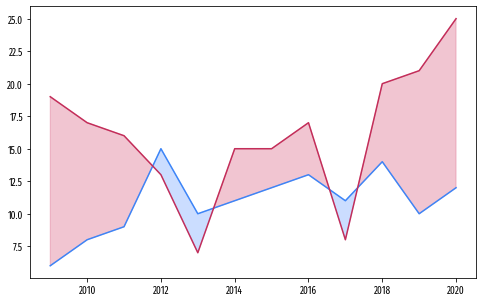

In [10]:
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Let's say we select the borough named "Enfield" 
df = rescues_borough[rescues_borough["name"] == "Enfield"]

# YEAR represents the x-axis
YEAR = df["cal_year"].values
# There are two variables for the y-axis:
# the count for the cat rescues, and the count for non-cat rescues.
CAT = df["Cat"].values
NOT_CAT = df["Not_Cat"].values

# Add lines
ax.plot(YEAR, CAT, color=BLUE)
ax.plot(YEAR, NOT_CAT, color=PINK)

# Add fill between the two lines.
# Two `fill_between` calls are needed to have two different colors.
# First, a fill when CAT is larger than NOT_CAT
ax.fill_between(
    YEAR, CAT, NOT_CAT, where=(CAT > NOT_CAT), 
    interpolate=True, color=BLUE_LIGHT, alpha=0.3
)

# Then, a fill when CAT is not larger than NOT_CAT
ax.fill_between(
    YEAR, CAT, NOT_CAT, where=(CAT <= NOT_CAT),
    interpolate=True, color=PINK_LIGHT, alpha=0.3
);

# Note:
# Setting `interpolate` to `True` calculates the intersection point
# between the two lines and extends the filled region up to this point.

## Customize layout

The chart above is a good start. Not too hard, not too impressive. The subplots in the original chart look much better. Let's improve this one too!

This step consists of tweaking many details in the layout. Have a look at the comments to follow along step-by-step!

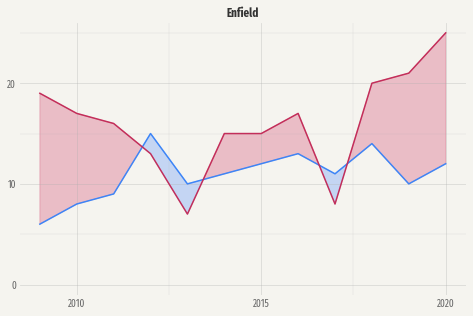

In [11]:
# Change the background color of both the axis and the figure
ax.set_facecolor(BACKGROUND)
fig.set_facecolor(BACKGROUND)

# Customize x-axis ticks 
# Note there are both major and minor ticks.
xticks = [2010, 2015, 2020]
ax.set_xticks(xticks) # major ticks
ax.set_xticks([2012.5, 2017.5], minor=True)
# Set a grey color for the labels
ax.set_xticklabels(xticks, color=GREY40)

# Customize y-axis ticks. 
# Also uses both minor and major ticks
yticks = [0, 10, 20]
ax.set_yticks(yticks)
ax.set_yticks([5, 15, 25], minor=True)
ax.set_yticklabels(yticks, color=GREY40)
# Also set a slightly larger range for the y-axis limit.
ax.set_ylim((-1, 26))

# Add grid lines.
# Note minor and major lines have different styles applied.
ax.grid(which="minor", lw=0.4, alpha=0.4)
ax.grid(which="major", lw=0.8, alpha=0.4)

# Remove tick marks by setting their length to zero on both axis.
ax.yaxis.set_tick_params(which="both", length=0)
ax.xaxis.set_tick_params(which="both", length=0)

# Remove all the spines by setting their color to "none"
ax.spines["left"].set_color("none")
ax.spines["bottom"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# And finally add the title
ax.set_title("Enfield", weight="bold", color=GREY20)

fig

A great step forward!

## Multi panel plot

The original plot is made of many of plots like the one above. So far, we've successfully replicated only a single panel (or subplot in Matplotlib's jargon). All of that can be reused in this section. 

Let's start by defining a function that encapsulates all the steps performed above. Some comments are added to explain little changes.

In [12]:
## Here's a summary of the meaning of the arguments in the function
# x: array of values for the year
# y1: array of values for the number of cat rescues
# y2: array of values for the number of non-cat rescues
# name: name of the borough
# ax: the Matplotlib axis where to plot

def single_plot(x, y1, y2, name, ax):
    
    ax.plot(x, y1, color=BLUE)
    ax.plot(x, y2, color=PINK)

    ax.fill_between(
        x, y1, y2, where=(y1 > y2), 
        interpolate=True, color=BLUE_LIGHT, alpha=0.3
    )

    ax.fill_between(
        x, y1, y2, where=(y1 <= y2),
        interpolate=True, color=PINK_LIGHT, alpha=0.3
    );

    ax.set_facecolor(BACKGROUND)
    fig.set_facecolor(BACKGROUND)


    xticks = [2010, 2015, 2020]
    ax.set_xticks(xticks)
    ax.set_xticks([2012.5, 2017.5], minor=True)
    # added a 'size' argument
    ax.set_xticklabels(xticks, color=GREY40, size=10)

    yticks = [0, 10, 20]
    ax.set_yticks(yticks)
    ax.set_yticks([5, 15, 25], minor=True)
    # added a 'size' argument
    ax.set_yticklabels(yticks, color=GREY40, size=10)
    ax.set_ylim((-1, 26))

    ax.grid(which="minor", lw=0.4, alpha=0.4)
    ax.grid(which="major", lw=0.8, alpha=0.4)
    
    ax.yaxis.set_tick_params(which="both", length=0)
    ax.xaxis.set_tick_params(which="both", length=0)
    
    ax.spines["left"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    # added a 'size' argument
    ax.set_title(name, weight="bold", size=9, color=GREY20)

Before starting, it's important to determine the number of rows and columns in the multipanel layout. This can be determined by the length of unique values for `"row"` and `"col"` in `rescues_borough`.

In [13]:
NROW = len(rescues_borough["row"].unique())
NCOL = len(rescues_borough["col"].unique())

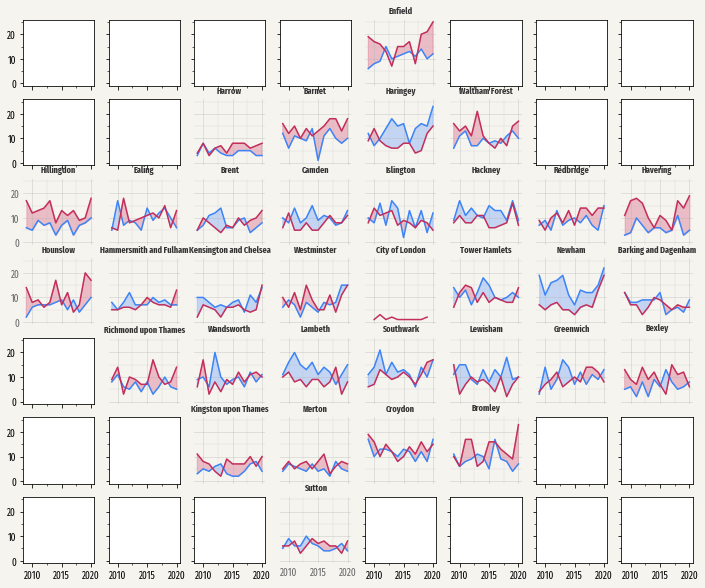

In [14]:
fig, axes = plt.subplots(NROW, NCOL, figsize=(12, 10), sharex=True, sharey=True)

for i, name in enumerate(NAMES):
    # Select data for the borough in 'name'
    df = rescues_borough[rescues_borough["name"] == name]
    
    # Take axis out of the axes array
    ax = axes[ROWS[i], COLS[i]]
    
    # Take values for x, y1 and y2.
    YEAR = df["cal_year"].values
    CAT = df["Cat"].values
    NOT_CAT = df["Not_Cat"].values
    
    # Plot it!
    single_plot(YEAR, CAT, NOT_CAT, name, ax)

What a change! There's so much going on here. The first thing to note is that not only the plots were added in the right place, but they also look exactly like the ones we're trying to replicate. That's a great start!

## Remove empty panels

On the other hand, there are many empty panels that shouldn't stay there. Fortunately, there's a method called `.remove()` that does exactly what its name says: call `ax.remove()` and the axis selected will be removed from the plot. Let's do it!

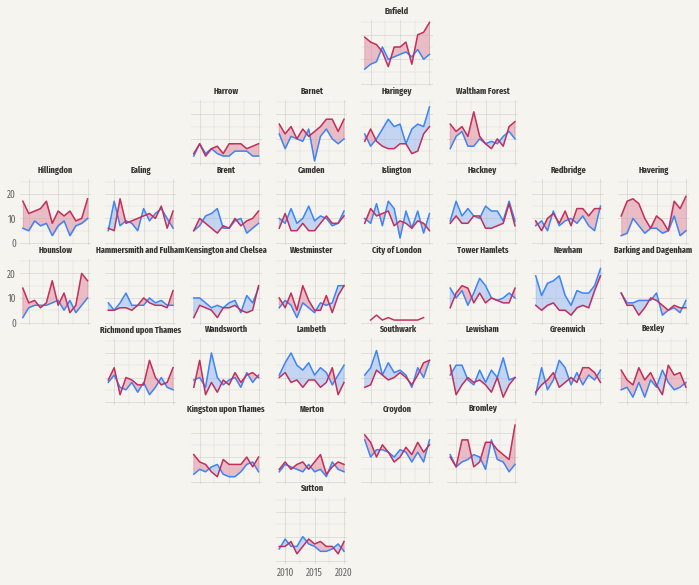

In [15]:
# Itereate trough rows
for i in range(7):
    # Iterate through columns
    for j in range(8):
        # Since we've added lines, we can check whether the plot is not empty by
        # checking whether the axis contains lines.
        # If it contains lines, we continue looping without removing the axis.
        if axes[i, j].lines:
            continue
        # If it does not contain lines, remove it!
        else:
            axes[i, j].remove()
fig

Nice move! Removing the empty axes had a noticeably positive effect on the plot. However, if you compare the chart obtained so far with the one introduced above, you may notice that tick labels are missing in many panels.

By default, when `sharex=True` and `sharey=True` are set, Matplotlib only uses y-tick labels for the panels on the first column and x-tick labels for the panel on the bottom row. This actually makes a lot of sense in a normal rectangular layout since repeating the same labels on every panel would only result in unnecessary clutter.

But this isn't just a rectangular layout and we want tick labels back in very custom locations. In this case, they are not going to be placed in the panels on the first column or last row. They are going to be located in the panels on the first column or last row that **isn't empty**.

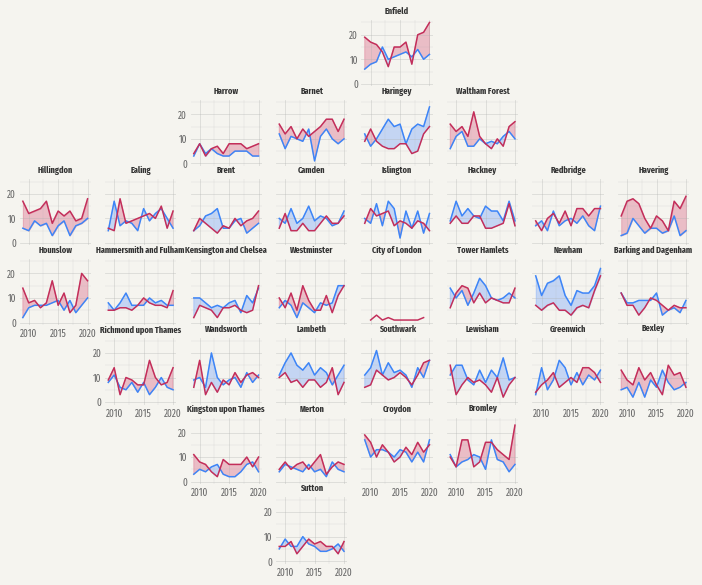

In [16]:
# Go through panels in a rowwise manner, from left to right.
for i in range(7):
    first_in_row = True
    for j in range(8):
        # Enable tick labels in the first panel in the row that is not empty.
        if first_in_row and axes[i, j].lines:
            axes[i, j].yaxis.set_tick_params(labelleft=True)
            first_in_row = False


# Go through panels in a columnwise manner, from bottom to top.
for j in range(8):
    first_in_col = True
    for i in reversed(range(7)): # note the 'reversed()'
        # Enable tick labels in the first panel in the column that is not empty.
        if first_in_col and axes[i, j].lines:
            axes[i, j].xaxis.set_tick_params(labelbottom=True)
            first_in_col = False

fig

Isn't it amazing to see all the details one can customize with Matplotlib?

## Add legends and annotations

The chart above is just one step away from being finished. This last step is about adding a good-looking title, a legend to tell the readers how to read the lines and the filled areas, and adjusting the margin and space between subplots.

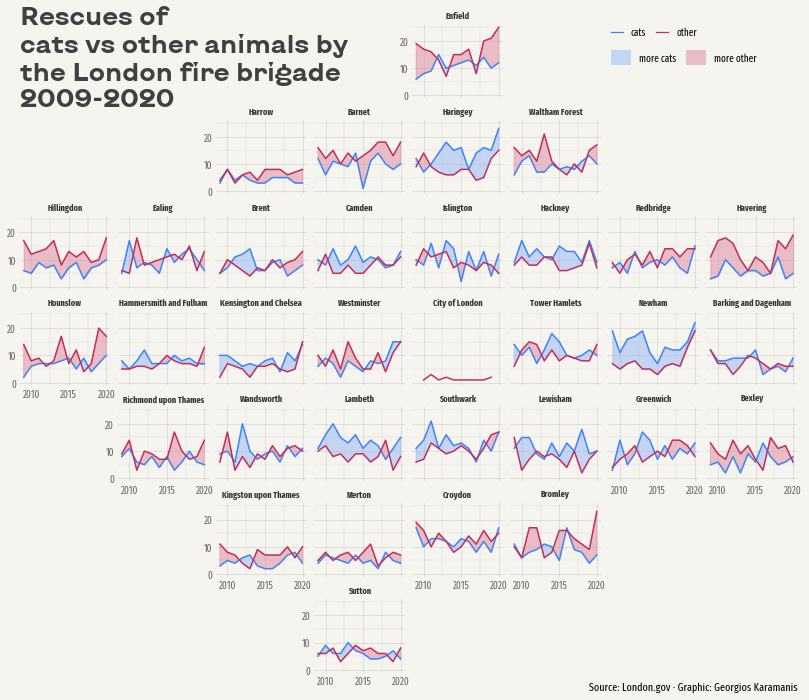

In [17]:
# Create handles for lines.
handles = [
    Line2D([], [], c=color, lw=1.2, label=label)
    for label, color in zip(["cats", "other"], [BLUE, PINK])
]

# Add legend for the lines
fig.legend(
    handles=handles,
    loc=(0.75, 0.94), # This coord is bottom-left corner
    ncol=2,           # 1 row, 2 columns layout
    columnspacing=1,  # Space between columns
    handlelength=1.2, # Line length
    frameon=False     # No frame
)


# Create handles for the area fill with `patches.Patch()`
cats = patches.Patch(facecolor=BLUE_LIGHT, alpha=0.3, label="more cats")
other = patches.Patch(facecolor=PINK_LIGHT, alpha=0.3, label="more other")

fig.legend(
    handles=[cats, other],
    loc=(0.75, 0.9), # This coord is bottom-left corner
    ncol=2,          # 1 row, 2 columns layout
    columnspacing=1, # Space between columns
    handlelength=2,  # Area length
    handleheight=2,  # Area height
    frameon=False,   # No frame
)

# Title
# Note the horizontal alignment, vertical alignment and multiline alignment values.
# They are not casual!
fig.text(
    x=0.05, y=0.975, s="Rescues of\ncats vs other animals by\nthe London fire brigade\n2009-2020",
    color=GREY25, fontsize=26, fontfamily="KyivType Sans", fontweight="bold",
    ha="left", # 'x' is the left limit of the title
    va="top",  # 'y' is the top limit of the title
    ma="left"  # multiple lines are aligned to the left
)

# Add caption
fig.text(
    x=0.95, y=0.025, s="Source: London.gov · Graphic: Georgios Karamanis", 
    fontsize=11, 
    ha="right",   # 'x' is the right location of the caption
    va="baseline" # 'y' is the base location of the caption
)

# Last but not least, customize the margin and space within subplots
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.3, wspace=0.08)
fig

#fig.savefig("plot.png", dpi=320) # to save it in high quality